In [1]:
import os 

import numpy as np
import matplotlib.pyplot as plt
import imageio as iio

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, PyTree 

import optax
import equinox as eqx

from tqdm import tqdm, trange

### load data

In [2]:
import os
images = np.zeros((3743,480,553,4))

ii = 0
for i in trange(len(os.listdir('/pscratch/sd/s/seanjx/images'))):
    image = os.listdir('/pscratch/sd/s/seanjx/images')[i]
    if not "DS_Store" in image and not "ipynb" in image:
        images[ii] = iio.imread("/pscratch/sd/s/seanjx/images/"+image)
        ii += 1

/tmp/ipykernel_279617/4049043409.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images[ii] = iio.imread("/pscratch/sd/s/seanjx/images/"+image)
100%|██████████| 3743/3743 [00:50<00:00, 74.82it/s]


In [3]:
images = jnp.array(images[...,:3].transpose(0,3,1,2)/255)

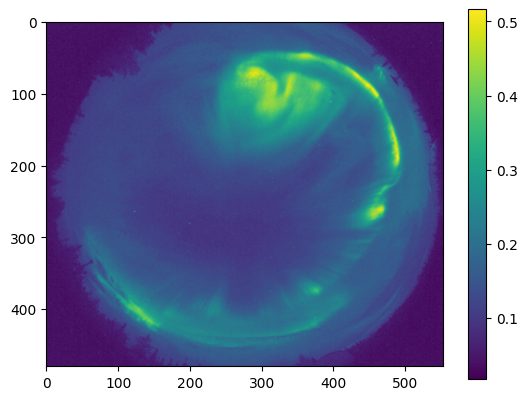

(3, 480, 553)

In [5]:
image = images[3100]
# plt.imshow(jnp.einsum('ijk,jk->jki',image, mask))
plt.imshow(jnp.mean(image,axis=0))#.transpose(1,2,0))
plt.colorbar()
plt.show()
image.shape

In [6]:
### normalize
means = jnp.mean(images, axis=(0,2,3))
stds = jnp.std(images,axis=(0,2,3))
images = ((images.transpose(0,3,2,1)-means)/stds).transpose(0,3,2,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1657625..6.5347567].


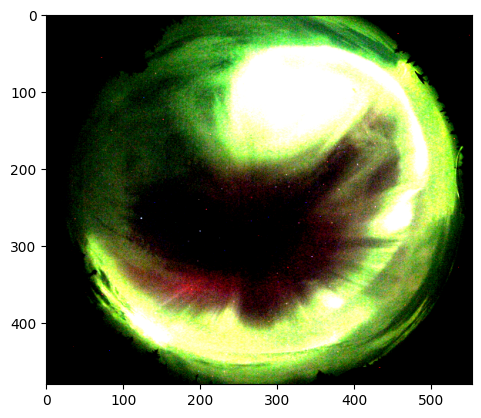

In [7]:
plt.imshow(images[3100].transpose(1,2,0))

### model specification

In [8]:
class Encoder(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4, key5, key6, key7, key8, key9 = jax.random.split(key, 9)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(3, 48, kernel_size=3, key=key1, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key2, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key3, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key4, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            jnp.ravel,
            eqx.nn.Linear(48960, 8192, key=key5),
            jax.nn.elu,
            eqx.nn.Linear(8192, 1024, key=key6),
            jax.nn.elu,
            eqx.nn.Linear(1024, 64, key=key7),
            jax.nn.tanh,
        ]

    def __call__(self, x: Float[Array, "3 480 553"]):
        for layer in self.layers:
            x = layer(x)
        return x


class Decoder(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4, key5, key6, key7, key8, key9 = jax.random.split(key, 9)
        self.layers = [
            eqx.nn.Linear(64, 1024, key=key1),
            jax.nn.elu,
            eqx.nn.Linear(1024, 8192, key=key2),
            jax.nn.elu,
            eqx.nn.Linear(8192, 48960, key=key3),
            jax.nn.elu,
            lambda x: jnp.reshape(x,(48,30,34)),
            lambda x: jax.image.resize(x,(48,60,68),"nearest"),
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key9, padding=1, padding_mode='REPLICATE'),
            lambda x: jax.image.resize(x,(48,120,136),"nearest"),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key5, padding=1, padding_mode='REPLICATE'),
            lambda x: jax.image.resize(x,(48,240,272),"nearest"),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key6, padding=1, padding_mode='REPLICATE'),
            lambda x: jax.image.resize(x,(48,480,553),"nearest"),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 3, kernel_size=3, key=key7, padding=1, padding_mode='REPLICATE'),
            lambda x: 10*jax.nn.tanh(x)
            # jax.nn.relu,
        ]
    @eqx.filter_jit
    def __call__(self, x: Float[Array, "3 480 553"]):
        for layer in self.layers:
            x = layer(x)
        return x

class Autoencoder(eqx.Module):
    layers: list
    def __init__(self, key):
        key1, key2 = jax.random.split(key,2)
        self.layers = [
            Encoder(key1),
            Decoder(key2)
        ]
    @eqx.filter_jit
    def __call__(self, x: Float[Array, "3 480 553"]) -> Float[Array, "3 480 553"]:
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
def loss(
    model: Autoencoder, x: Float[Array, "3 480 553"]
) -> Float[Array, ""]:
    
    pred = jax.vmap(model)(x)
    # return jnp.mean(jnp.sum((x-pred)**2,axis=(1,2,3)))
    return jnp.mean(jnp.sum(((x.transpose(0,2,3,1)*stds-means)-(pred.transpose(0,2,3,1)*stds-means))**2,axis=(1,2,3)))
    # return jnp.mean(jnp.sum(jnp.clip(jnp.mean(x,axis=0),1e-3)*mask*(x-pred)**2, axis=(1,2,3)))
    # return jnp.mean(jnp.sum(mask*(x-pred)**2, axis=(1,2,3)))

In [10]:
key = jax.random.key(0)
model = Autoencoder(key)
sum(x.size for x in jax.tree.leaves(eqx.partition(model,eqx.is_array)[0]))

819263731

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1657625..6.5347567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47357297..0.3148647].


Text(0.5, 1.0, 'recreation')

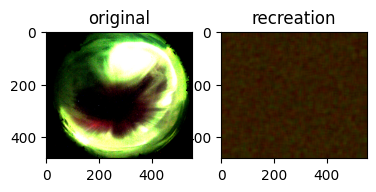

In [11]:
plt.figure()
plt.subplot(231)
plt.imshow(images[3100].transpose(1,2,0))
plt.title('original')
plt.subplot(232)
plt.imshow(model(images[3100]).transpose(1,2,0))
plt.title('recreation')

In [12]:
loss_value, grads = eqx.filter_value_and_grad(loss)(model, jnp.array([images[3100]]))
print(loss_value, grads.layers[0].layers[0].weight)

6515.6606 [[[[-0.00052975  0.0146056   0.02066302]
   [ 0.02281034  0.03506981  0.0371696 ]
   [ 0.0412403   0.03415599  0.03829721]]

  [[ 0.03892656  0.04289293  0.03880665]
   [ 0.06231427  0.0634794   0.05255805]
   [ 0.07863022  0.07679982  0.08822985]]

  [[ 0.00469887  0.00647433 -0.00729246]
   [ 0.0257517   0.01784804  0.00165974]
   [ 0.01574568  0.01050405  0.02576582]]]


 [[[ 0.14370286  0.14635551  0.14616069]
   [ 0.12482931  0.12091561  0.14003155]
   [ 0.09807007  0.10972657  0.12408589]]

  [[ 0.2538655   0.2533172   0.2599495 ]
   [ 0.25440735  0.25788814  0.2599591 ]
   [ 0.24409047  0.26300767  0.26807547]]

  [[ 0.04535387  0.05377123  0.04291598]
   [ 0.04829405  0.06082565  0.0545781 ]
   [ 0.02179151  0.04142629  0.06553423]]]


 [[[-0.04917987 -0.03850234 -0.04311934]
   [-0.04997296 -0.06110654 -0.05616952]
   [-0.04451974 -0.04997114 -0.05704197]]

  [[-0.08117073 -0.07532892 -0.07894795]
   [-0.07678416 -0.07607394 -0.07989918]
   [-0.07451986 -0.0820945  -

### training

In [13]:
from jax.sharding import NamedSharding, PartitionSpec
dev_cnt = len(jax.devices())
mesh = jax.make_mesh((dev_cnt,), ('device',))
sharding = NamedSharding(mesh, PartitionSpec('device'))

In [15]:
def train(
    model: Autoencoder,
    train,
    test,
    opt: optax.GradientTransformation,
    steps: int = 1000,
    batch_size: int = 16,
    test_freq: int = 10, #test every n batches
    rng = np.random.default_rng(0)
):
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def update(
        model: Autoencoder,
        opt_state: PyTree,
        x: Float[Array, "batch 3 480 553"],
    ):
        x = eqx.filter_shard(x, sharding)
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x)
        updates, opt_state = opt.update(
            grads, opt_state, eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_idx = rng.choice(np.arange(len(train)), size=(steps, batch_size))
    test_idx = rng.choice(np.arange(len(test)), size=(steps//test_freq, batch_size))

    min_loss = np.inf
    best_model = model
    train_losses = []
    test_losses = []
    loop = trange(steps)
    for step in loop:
        flip1 = -1 if step % 4 == 1 or step % 4 == 3 else 1
        flip2 = -1 if step % 4 == 2 or step % 4 == 3 else 1
        model, opt_state, train_loss = update(model, opt_state, images[train[train_idx[step]]][...,::flip1,::flip2])
        train_losses.append(train_loss)
        if train_loss < min_loss:
            min_loss = train_loss
            best_model = model
        if (step % test_freq) == 0 or (step == steps - 1):
            test_loss = loss(model, images[test[test_idx[step//test_freq]]])
            test_losses.append(test_loss)
        loop.set_postfix_str(f'training loss: {train_loss:.3e}')
    return model, train_losses, test_losses

In [16]:
# rng = np.random.default_rng(0)
# permutation = rng.permutation(np.arange(3743))
# trainset = images[permutation[:3000]]
# testset = images[permutation[3000:]]
# del images
rng = np.random.default_rng(0)
permutation = rng.permutation(np.arange(3743))
trainset = permutation[:3500]
testset = permutation[3500:]

In [17]:
schedule_fn = optax.polynomial_schedule(init_value=1e-4, end_value=1e-6, power=0.5, transition_steps=12000)
opt = optax.adabelief(schedule_fn,b1=0.95,b2=0.99)
model, train_losses, test_losses = train(
    model, 
    trainset, 
    testset, 
    opt, 
    steps=12000, batch_size=64, test_freq=50, rng=rng)

2025-12-15 18:09:39.234591: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 18:09:39.234635: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
100%|██████████| 12000/12000 [20:19<00:00,  9.84it/s, training loss: 1.228e+02]


122.83282 88.942314 11595
172.28831 99.71803 215


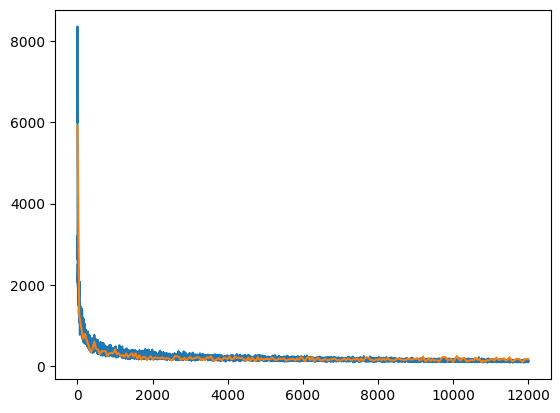

In [77]:
plt.plot(train_losses)
plt.plot(np.arange(12000//50+1)*50,test_losses)
print(train_losses[-1], np.nanmin(train_losses), np.nanargmin(train_losses))
print(test_losses[-1], np.nanmin(test_losses), np.nanargmin(test_losses))
plt.show()

In [53]:
from astropy.visualization import simple_norm
def pixel_loss(
    model: Autoencoder, x: Float[Array, "3 480 553"]
) -> Float[Array, ""]:
    
    pred = model(x)
    return jnp.sum(((x.transpose(1,2,0)*stds-means)-(pred.transpose(1,2,0)*stds-means))**2,axis=2)

/tmp/ipykernel_279617/3394137774.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = ((iio.imread('/pscratch/sd/s/seanjx/pina_frame_0000271.png')[...,:3]-stds)/means).transpose(2,0,1)/255


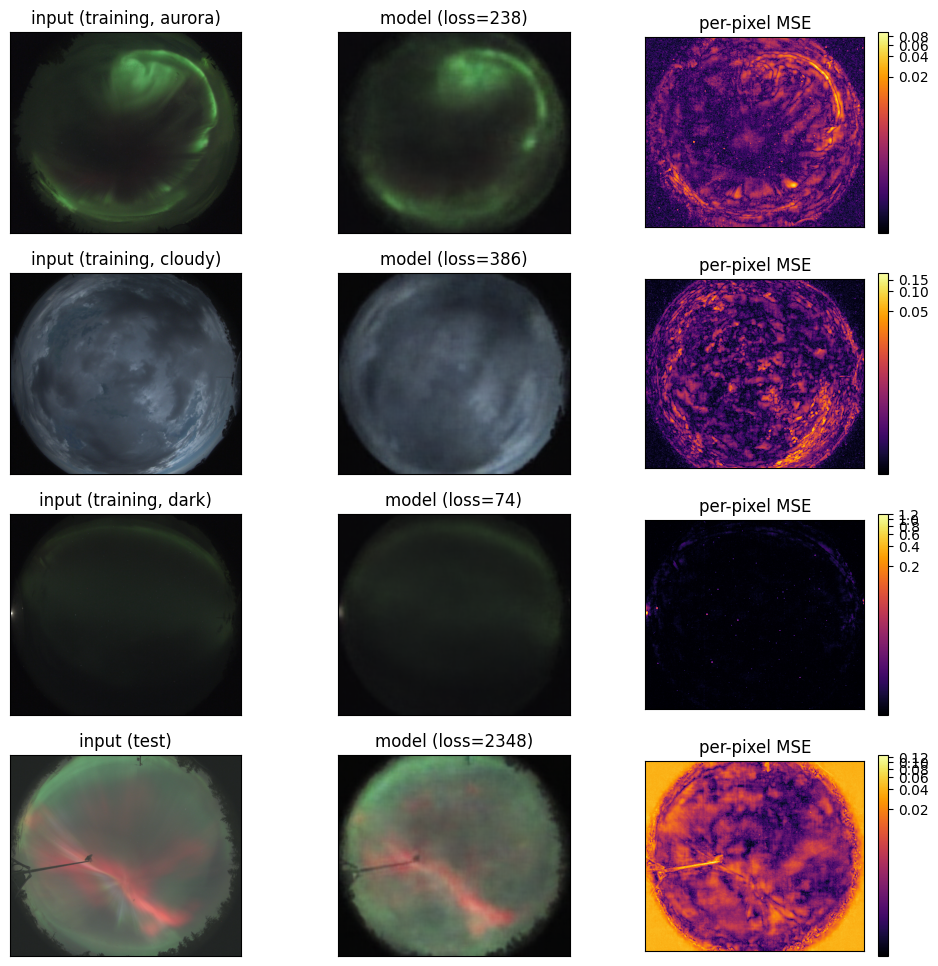

In [76]:
image = images[3100][:,::1,::1]#images[testset[0]][:,::1,:]
residuals = pixel_loss(model, image)

plt.figure(figsize=(12,12))
plt.subplot(431)
plt.imshow(image.transpose(1,2,0)*stds+means)
plt.title('input (training, aurora)')
plt.xticks([])
plt.yticks([])
plt.subplot(432)
plt.imshow(model(image).transpose(1,2,0)*stds+means)
plt.title(f'model (loss={loss(model,jnp.array([image])):.0f})')
plt.xticks([])
plt.yticks([])
plt.subplot(433)
norm = simple_norm(residuals, 'log')
plt.imshow(residuals, norm=norm, cmap='inferno')
plt.colorbar()
plt.title('per-pixel MSE')
plt.xticks([])
plt.yticks([])

image = images[2100][:,::1,::1]#images[testset[0]][:,::1,:]
residuals = pixel_loss(model, image)

plt.subplot(434)
plt.imshow(image.transpose(1,2,0)*stds+means)
plt.title('input (training, cloudy)')
plt.xticks([])
plt.yticks([])
plt.subplot(435)
plt.imshow(model(image).transpose(1,2,0)*stds+means)
plt.title(f'model (loss={loss(model,jnp.array([image])):.0f})')
plt.xticks([])
plt.yticks([])
plt.subplot(436)
norm = simple_norm(residuals, 'log')
plt.imshow(residuals, norm=norm, cmap='inferno')
plt.colorbar()
plt.title('per-pixel MSE')
plt.xticks([])
plt.yticks([])

image = images[1100][:,::1,::1]#images[testset[0]][:,::1,:]
residuals = pixel_loss(model, image)

plt.subplot(437)
plt.imshow(image.transpose(1,2,0)*stds+means)
plt.title('input (training, dark)')
plt.xticks([])
plt.yticks([])
plt.subplot(438)
plt.imshow(model(image).transpose(1,2,0)*stds+means)
plt.title(f'model (loss={loss(model,jnp.array([image])):.0f})')
plt.xticks([])
plt.yticks([])
plt.subplot(439)
norm = simple_norm(residuals, 'log')
plt.imshow(residuals, norm=norm, cmap='inferno')
plt.colorbar()
plt.title('per-pixel MSE')
plt.xticks([])
plt.yticks([])

image = ((iio.imread('/pscratch/sd/s/seanjx/pina_frame_0000271.png')[...,:3]-stds)/means).transpose(2,0,1)/255
residuals = pixel_loss(model, image)

plt.subplot(4,3,10)
plt.imshow(image.transpose(1,2,0)*stds+means)
plt.title('input (test)')
plt.xticks([])
plt.yticks([])
plt.subplot(4,3,11)
plt.imshow(model(image).transpose(1,2,0)*stds+means)
plt.title(f'model (loss={loss(model,jnp.array([image])):.0f})')
plt.xticks([])
plt.yticks([])
plt.subplot(4,3,12)
norm = simple_norm(residuals, 'log')
plt.imshow(residuals, norm=norm, cmap='inferno')
plt.colorbar()
plt.title('per-pixel MSE')
plt.xticks([])
plt.yticks([])
plt.show()

In [56]:
eqx.tree_serialise_leaves("/pscratch/sd/s/seanjx/model48.eqx", model)